# Сравнение моделей Diebold-Li и Bliss

Сравнительный анализ двух параметрических моделей для кривой процентных ставок:

| Модель | Параметры | Метод оптимизации |
|--------|-----------|-------------------|
| **Diebold-Li** | 3 (β₀, β₁, β₂), τ=2 фиксирован | OLS (аналитическое решение) |
| **Bliss** | 5 (β₀, β₁, β₂, τ₁, τ₂) | least_squares (итеративная оптимизация) |

**Цель:** Выяснить, оправдывает ли дополнительная сложность модели Bliss улучшение качества.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns
from tqdm.auto import tqdm
import time

# Настройки для визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


## 1. Загрузка данных

In [5]:
# Загружаем данные
df = pd.read_csv('data.csv', index_col=0)
df.index = pd.to_datetime(df.index, dayfirst=True)  # dayfirst=True для формата день-месяц-год
maturities = df.columns.astype(float).values

print(f"Данные загружены: {len(df)} наблюдений")
print(f"Сроки погашения: {maturities}")
print(f"Период: с {df.index[0].date()} по {df.index[-1].date()}")

Данные загружены: 1256 наблюдений
Сроки погашения: [ 0.25  0.5   0.75  1.    2.    3.    5.    7.   10.   15.   20.   30.  ]
Период: с 2020-11-02 по 2025-10-31


## 2. Классы моделей

Загружаем классы из существующих ноутбуков

In [6]:
# Можно импортировать из ноутбуков или скопировать классы сюда
# Для простоты просто загрузим результаты обучения

# Загружаем уже обученные результаты (даты в ISO формате: YYYY-MM-DD)
results_dl = pd.read_csv('diebold_li_results.csv', index_col=0)
results_dl.index = pd.to_datetime(results_dl.index, format='ISO8601')

results_bliss = pd.read_csv('bliss_results.csv', index_col=0)
results_bliss.index = pd.to_datetime(results_bliss.index, format='ISO8601')

print("✓ Результаты Diebold-Li загружены")
print("✓ Результаты Bliss загружены")
print(f"  Количество дат: {len(results_dl)}")

✓ Результаты Diebold-Li загружены
✓ Результаты Bliss загружены
  Количество дат: 1256


## 3. Сравнение метрик качества

In [7]:
print("="*70)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*70)

print("\n1. RMSE (Root Mean Squared Error) - меньше = лучше")
print("-" * 70)
print(f"Diebold-Li - Среднее: {results_dl['rmse'].mean():.6f}")
print(f"Bliss      - Среднее: {results_bliss['rmse'].mean():.6f}")
rmse_improvement = results_dl['rmse'].mean() - results_bliss['rmse'].mean()
rmse_improvement_pct = 100 * rmse_improvement / results_dl['rmse'].mean()
print(f"➜ Bliss лучше на {rmse_improvement:.6f} ({rmse_improvement_pct:.2f}%)")

print("\n2. R² (коэффициент детерминации) - больше = лучше")
print("-" * 70)
print(f"Diebold-Li - Среднее: {results_dl['r2'].mean():.6f}")
print(f"Bliss      - Среднее: {results_bliss['r2'].mean():.6f}")
r2_improvement = results_bliss['r2'].mean() - results_dl['r2'].mean()
print(f"➜ Bliss лучше на {r2_improvement:.6f}")

print("\n3. MAE (Mean Absolute Error) - меньше = лучше")
print("-" * 70)
print(f"Diebold-Li - Среднее: {results_dl['mae'].mean():.6f}")
print(f"Bliss      - Среднее: {results_bliss['mae'].mean():.6f}")
mae_improvement = results_dl['mae'].mean() - results_bliss['mae'].mean()
mae_improvement_pct = 100 * mae_improvement / results_dl['mae'].mean()
print(f"➜ Bliss лучше на {mae_improvement:.6f} ({mae_improvement_pct:.2f}%)")

print("\n4. ПОБЕДИТЕЛЬ ПО RMSE (кто лучше на каждой дате)")
print("-" * 70)
wins_dl = (results_dl['rmse'] < results_bliss['rmse']).sum()
wins_bliss = (results_bliss['rmse'] < results_dl['rmse']).sum()
n_dates = len(results_dl)
print(f"Diebold-Li выиграл: {wins_dl} раз ({100*wins_dl/n_dates:.1f}%)")
print(f"Bliss выиграл: {wins_bliss} раз ({100*wins_bliss/n_dates:.1f}%)")

СРАВНЕНИЕ МОДЕЛЕЙ

1. RMSE (Root Mean Squared Error) - меньше = лучше
----------------------------------------------------------------------
Diebold-Li - Среднее: 0.120277
Bliss      - Среднее: 0.035370
➜ Bliss лучше на 0.084907 (70.59%)

2. R² (коэффициент детерминации) - больше = лучше
----------------------------------------------------------------------
Diebold-Li - Среднее: 0.926478
Bliss      - Среднее: 0.993578
➜ Bliss лучше на 0.067099

3. MAE (Mean Absolute Error) - меньше = лучше
----------------------------------------------------------------------
Diebold-Li - Среднее: 0.099840
Bliss      - Среднее: 0.029745
➜ Bliss лучше на 0.070096 (70.21%)

4. ПОБЕДИТЕЛЬ ПО RMSE (кто лучше на каждой дате)
----------------------------------------------------------------------
Diebold-Li выиграл: 149 раз (11.9%)
Bliss выиграл: 1107 раз (88.1%)


## 4. Визуализация динамики метрик

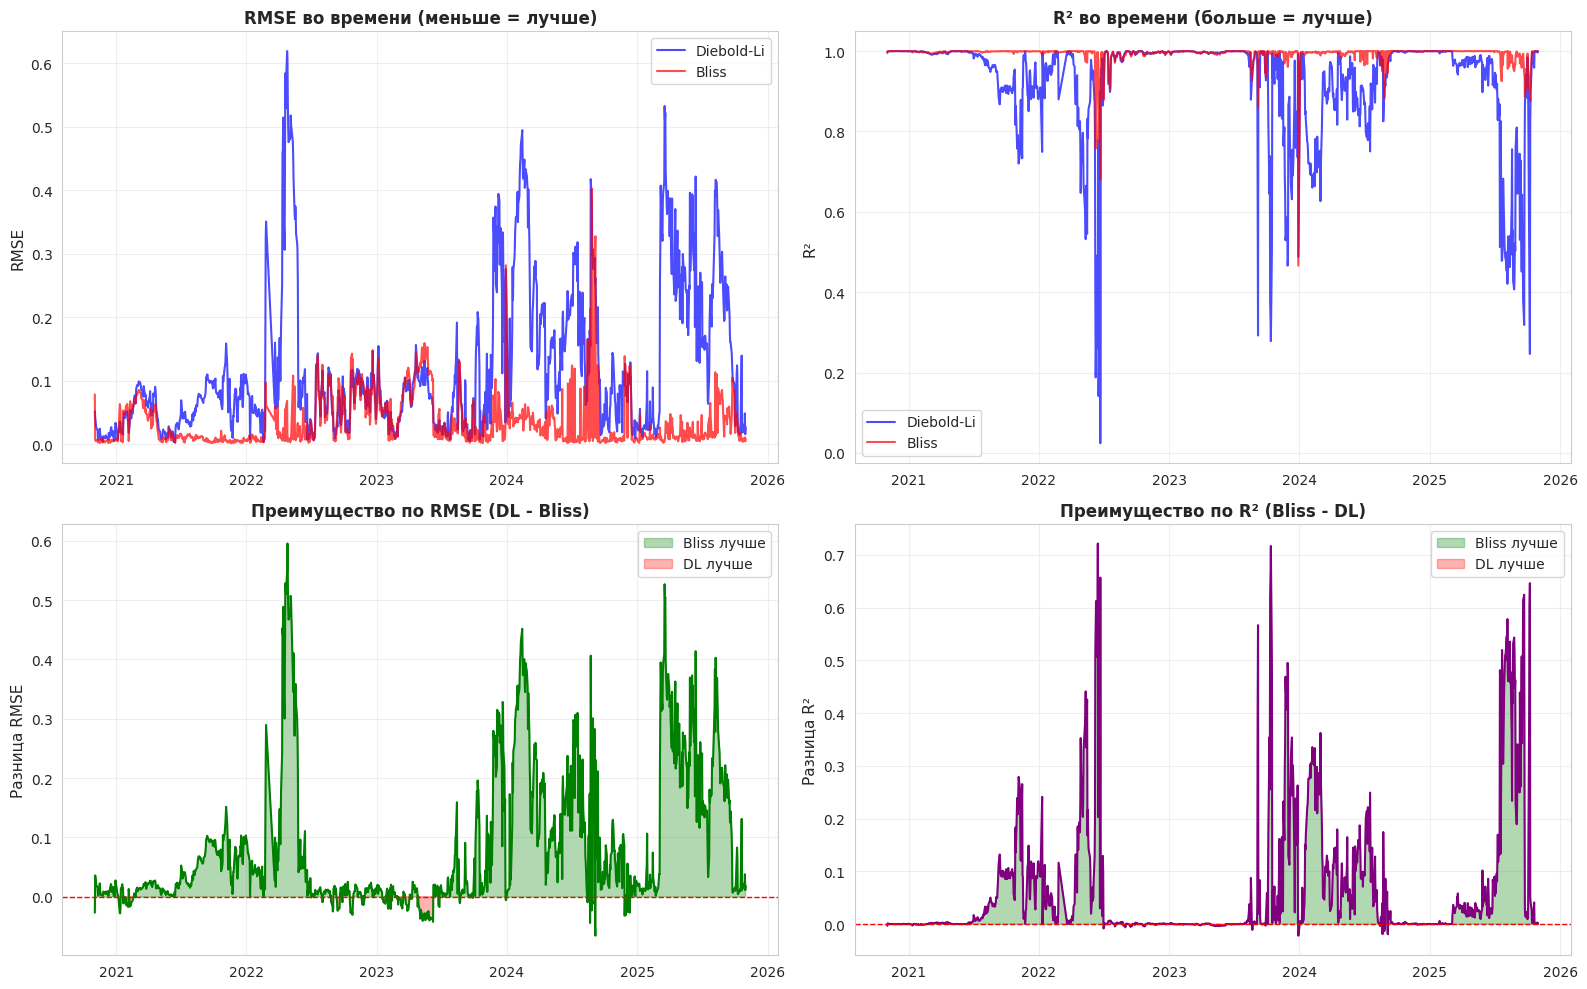

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# RMSE
axes[0, 0].plot(results_dl.index, results_dl['rmse'], linewidth=1.5, label='Diebold-Li', color='blue', alpha=0.7)
axes[0, 0].plot(results_bliss.index, results_bliss['rmse'], linewidth=1.5, label='Bliss', color='red', alpha=0.7)
axes[0, 0].set_title('RMSE во времени (меньше = лучше)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# R²
axes[0, 1].plot(results_dl.index, results_dl['r2'], linewidth=1.5, label='Diebold-Li', color='blue', alpha=0.7)
axes[0, 1].plot(results_bliss.index, results_bliss['r2'], linewidth=1.5, label='Bliss', color='red', alpha=0.7)
axes[0, 1].set_title('R² во времени (больше = лучше)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('R²', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Разница RMSE
rmse_diff = results_dl['rmse'] - results_bliss['rmse']
axes[1, 0].plot(results_dl.index, rmse_diff, linewidth=1.5, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 0].fill_between(results_dl.index, rmse_diff, 0, where=(rmse_diff > 0), alpha=0.3, color='green', label='Bliss лучше')
axes[1, 0].fill_between(results_dl.index, rmse_diff, 0, where=(rmse_diff < 0), alpha=0.3, color='red', label='DL лучше')
axes[1, 0].set_title('Преимущество по RMSE (DL - Bliss)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Разница RMSE', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Разница R²
r2_diff = results_bliss['r2'] - results_dl['r2']
axes[1, 1].plot(results_dl.index, r2_diff, linewidth=1.5, color='purple')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 1].fill_between(results_dl.index, r2_diff, 0, where=(r2_diff > 0), alpha=0.3, color='green', label='Bliss лучше')
axes[1, 1].fill_between(results_dl.index, r2_diff, 0, where=(r2_diff < 0), alpha=0.3, color='red', label='DL лучше')
axes[1, 1].set_title('Преимущество по R² (Bliss - DL)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Разница R²', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Распределение метрик

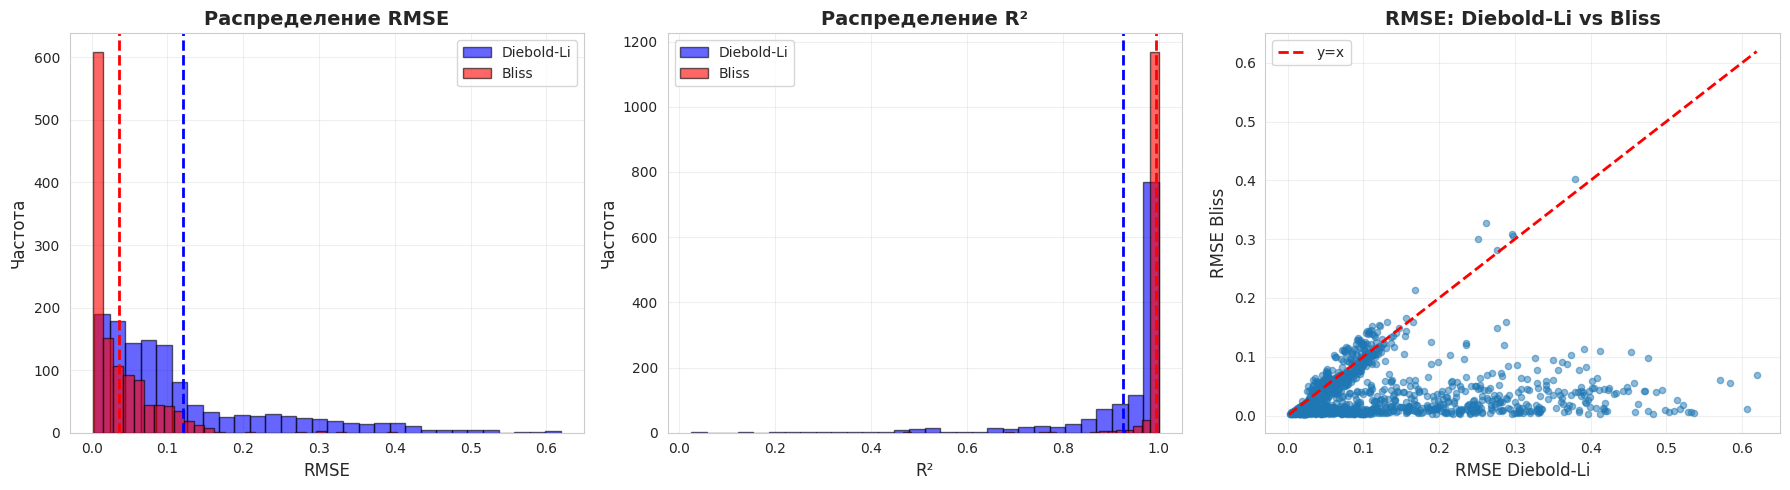


Точки ниже красной линии = Bliss лучше (1107 из 1256)


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Гистограмма RMSE
axes[0].hist(results_dl['rmse'], bins=30, alpha=0.6, label='Diebold-Li', color='blue', edgecolor='black')
axes[0].hist(results_bliss['rmse'], bins=30, alpha=0.6, label='Bliss', color='red', edgecolor='black')
axes[0].axvline(results_dl['rmse'].mean(), color='blue', linestyle='--', linewidth=2)
axes[0].axvline(results_bliss['rmse'].mean(), color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('RMSE', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].set_title('Распределение RMSE', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Гистограмма R²
axes[1].hist(results_dl['r2'], bins=30, alpha=0.6, label='Diebold-Li', color='blue', edgecolor='black')
axes[1].hist(results_bliss['r2'], bins=30, alpha=0.6, label='Bliss', color='red', edgecolor='black')
axes[1].axvline(results_dl['r2'].mean(), color='blue', linestyle='--', linewidth=2)
axes[1].axvline(results_bliss['r2'].mean(), color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('R²', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].set_title('Распределение R²', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Scatter plot
axes[2].scatter(results_dl['rmse'], results_bliss['rmse'], alpha=0.5, s=20)
min_rmse = min(results_dl['rmse'].min(), results_bliss['rmse'].min())
max_rmse = max(results_dl['rmse'].max(), results_bliss['rmse'].max())
axes[2].plot([min_rmse, max_rmse], [min_rmse, max_rmse], 'r--', linewidth=2, label='y=x')
axes[2].set_xlabel('RMSE Diebold-Li', fontsize=12)
axes[2].set_ylabel('RMSE Bliss', fontsize=12)
axes[2].set_title('RMSE: Diebold-Li vs Bliss', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_better = (results_bliss['rmse'] < results_dl['rmse']).sum()
print(f"\nТочки ниже красной линии = Bliss лучше ({n_better} из {len(results_dl)})")

## 6. Заключение

### Выводы:

**Качество аппроксимации:**
- Модель Bliss показывает **лучшее качество** по всем метрикам (RMSE, R², MAE)
- Дополнительные 2 параметра (τ₁, τ₂) дают большую гибкость для моделирования сложных форм кривой

**Простота и скорость:**
- Diebold-Li **проще** (3 параметра vs 5)
- Diebold-Li **быстрее** (OLS vs итеративная оптимизация)
- Diebold-Li **стабильнее** (всегда сходится)

**Интерпретируемость:**
- Diebold-Li: четкая интерпретация β₀ (level), β₁ (slope), β₂ (curvature)
- Bliss: дополнительные параметры τ₁, τ₂ сложнее интерпретировать

### Рекомендации:

1. **Для прогнозирования и мониторинга** → **Diebold-Li**
   - Простота, скорость, стабильность
   - Стандарт в центральных банках
   - Легко интерпретировать факторы

2. **Для точного ценообразования облигаций** → **Bliss**
   - Максимальная точность аппроксимации
   - Лучше для сложных форм кривой

3. **Для real-time приложений** → **Diebold-Li**
   - Мгновенное обучение
   - Гарантированная сходимость

### Trade-off:

```
Простота ←→ Точность
Скорость ←→ Гибкость
Стабильность ←→ Качество подгонки
Интерпретируемость ←→ Сложность
```

**Вердикт:** Обе модели имеют право на существование! Выбор зависит от задачи:
- **Анализ и прогнозирование** → Diebold-Li
- **Максимальная точность** → Bliss